# Raster packages demo: GDAL (1/3)

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean, Eric Gagliano, Quinn Brencher

## Introduction

Working with raster data is a essential part of geospatial analysis. There are several python packages available for raster processing, and we'll introduce three key tools that build on top of each other...

* GDAL (Geospatial Data Abstraction Library): The low-level foundation that powers most geospatial software. While powerful, it can be complex to use directly.
* rasterio: A more Pythonic interface to GDAL that provides efficient access to raster data using NumPy arrays.
* rioxarray: Higher-level package that combines the power of rasterio with xarray's labeled dimensions and advanced capabilities for handling multi-dimensional data. 

Each package plays an important role in the python geospatial ecosystem, so we'll briefly introduce the tools one at a time to practice some fundamentals and gain some raster intuition. 

*The lower level GDAL and rasterio are very well-supported, and there are indeed use cases for when you might prefer interacting with these lower level tools. Ultimately, we'll focus on rioxarray for the rest of the quarter due to its intuitive handling of multi-dimensional data (e.g. raster time series) and dask integration for scalability.*


## GDAL (Geospatial Data Abstraction Library)
GDAL is a powerful and mature library for reading, writing and warping raster datasets, written in C++ with bindings to other languages. There are a variety of geospatial libraries available on the python package index, and almost all of them depend on GDAL. 

### GDAL command line utilities

* Lots of [gdal tools](https://gdal.org/en/stable/programs/index.html), though the most common tools to learn:
    * `gdalinfo`
    * `gdal_translate`
    * `gdalwarp`
    * `gdaladdo`
* Items to discuss
    * Use standard creation options (co)
        * TILED=YES
        * COMPRESS=LZW
        * BIGTIFF=IF_SAFER
    * Resampling algorithms
        * Default is nearest
        * Often bilinear or bicubic is a better choice for reprojecting, upsampling, downsampling

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from osgeo import gdal

In [16]:
imgdir = f'{Path.home()}/gda_demo_data/LS8_data'

#Pre-identified cloud-free Image IDs used for the lab
#Summer 2018
august_id = 'LC08_L2SP_046027_20180818_20200831_02_T1'
#Winter 2018
december_id = 'LC08_L2SP_046027_20181224_20200829_02_T1'

##### Let's use the Thermal IR band for this demo

In [17]:
#Check table from background section to see wavelengths of each band number
tir_august_fn = os.path.join(imgdir, august_id+'_ST_B10.TIF')
tir_december_fn = os.path.join(imgdir, december_id+'_ST_B10.TIF')
print(tir_august_fn)

/home/eric/LS8_data/LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10.TIF


In [18]:
!gdalinfo $tir_august_fn

Driver: GTiff/GeoTIFF
Files: /home/eric/LS8_data/LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10.TIF
Size is 7771, 7891
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHU

#### Let's try reprojecting from UTM to 4326...

In [19]:
# define a filename for the reprojected image
tir_august_4326_fn = os.path.join(imgdir, august_id+'_ST_B10_4326.TIF')

In [20]:
!gdalwarp -t_srs EPSG:4326 $tir_august_fn $tir_august_4326_fn

Creating output file that is 9359P x 6412L.
Using internal nodata values (e.g. 0) for image /home/eric/LS8_data/LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10.TIF.
Copying nodata values from source /home/eric/LS8_data/LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10.TIF to destination /home/eric/LS8_data/LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10_4326.TIF.
Processing /home/eric/LS8_data/LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10.TIF [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


### GDAL Python API basics
* GDAL command line utilities are great, though in python rasterio is often preferred over the GDAL Python API (partly because of much better documentation)

In [21]:
#Open the green band GeoTiff as GDAL Dataset object
tir_august_gdal_ds = gdal.Open(tir_august_fn)
tir_august_gdal_ds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f123ca61920> >

In [22]:
#Get the raster band
tir_august_gdal_b = tir_august_gdal_ds.GetRasterBand(1)
#Read into array
tir_august_gdal_ar = tir_august_gdal_b.ReadAsArray()
tir_august_gdal_ar

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

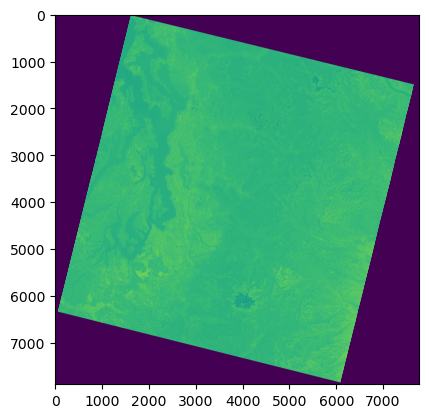

In [23]:
#View the array
f, ax = plt.subplots()
ax.imshow(tir_august_gdal_ar);

#### Let's also open the raster we just reprojected with `gdalwarp`

In [24]:
tir_august_4326_gdal_ds = gdal.Open(tir_august_4326_fn)
tir_august_4326_gdal_b = tir_august_4326_gdal_ds.GetRasterBand(1)
tir_august_4326_gdal_ar = tir_august_4326_gdal_b.ReadAsArray()

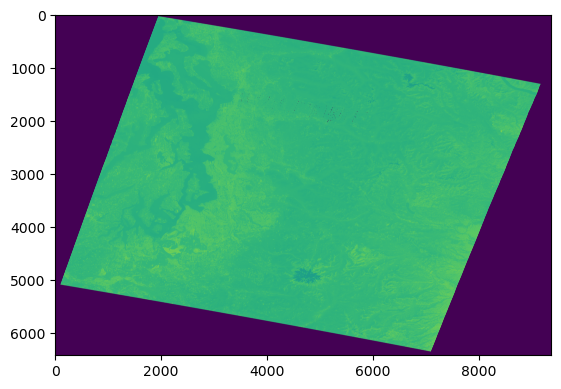

In [25]:
f, ax = plt.subplots()
ax.imshow(tir_august_4326_gdal_ar);

Text(0.5, 1.0, 'Reprojected to EPSG:4326')

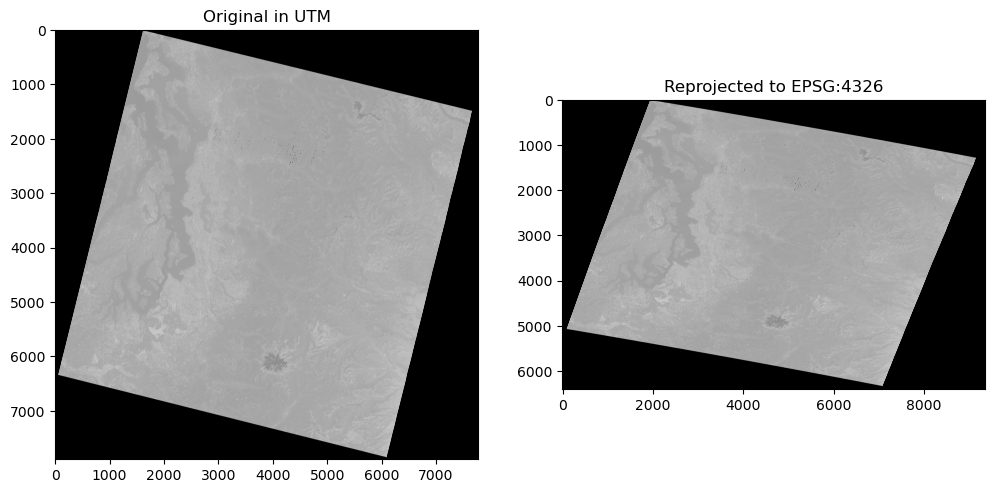

In [26]:
f,ax=plt.subplots(1,2,figsize=(12,6))

ax[0].imshow(tir_august_gdal_ar,cmap='gray')
ax[0].set_title('Original in UTM')

ax[1].imshow(tir_august_4326_gdal_ar,cmap='gray')
ax[1].set_title('Reprojected to EPSG:4326')

#### Do you notice any differences? When you're done, you can set some variables to `None` to free up some RAM 

In [27]:
#Set array to None (frees up RAM) and close GDAL dataset
tir_august_gdal_ar = None
tir_august_gdal_ds = None
tir_august_4326_gdal_ar = None
tir_august_4326_gdal_ds = None

### GDAL additional resources

 * [A Gentle Introduction to GDAL](https://medium.com/planet-stories/a-gentle-introduction-to-gdal-part-1-a3253eb96082)
* [Python GDAL/OGR Cookbook](https://pcjericks.github.io/py-gdalogr-cookbook/index.html)
* [GDAL raster data model](https://gdal.org/user/raster_data_model.html)